In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras.losses import mse
from functools import partial
import keras.backend as K
import sys
from keras.datasets import mnist
import seaborn as sns
from keras.utils import plot_model

# Dataset Load

We use dataset of bank marketing from https://archive.ics.uci.edu/ml/datasets/bank+marketing . Analysis is provided in VAE_BANK.ipynb

In [21]:
df = pd.read_csv('bank-full.csv', header = 0, sep = ';')

In [22]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [23]:
li_cat = ['poutcome', 'marital']
li_cont = ['age', 'balance', 'pdays', 'previous', 'campaign']

In [24]:
for i in li_cont:
    ser = df.loc[:, i]
    threshold = np.percentile(ser, 99)
    print (i, threshold)
    df.loc[ser>threshold, i] = threshold 

age 71.0
balance 13164.900000000001
pdays 370.0
previous 8.900000000001455
campaign 16.0


In the next step, we normalize continuous variables and use one-hot-encoding for categorical variable. This is implemented with encode() function, while decode() function makes reverse transformation: from normalized data to real data. Note, that data which are neededfor reverse transformation are saved in normalized.csv during encoding.

In [25]:
def add1(x):
    if x==-1: return x+1
    else: return x

def add1_revert(x):
    if x==0: return x-1
    else: return x

def encode(df, li_cat, li_cont, save_normalized=False, soft_labels=False):
    fname_norm = "normalized_gans.csv"
 
    ## categorial variables
    df_cat = df.loc[:,li_cat]
    df_cat = pd.get_dummies(df_cat)

    if soft_labels:
        for i in df_cat.columns:
            df_cat.loc[:, i] = df_cat.loc[:, i] - 0.3*np.random.random(len(df_cat))

    ## continuous variables
    df_cont = df.loc[:, li_cont]
    df_cont.pdays = df_cont.pdays.apply(lambda x: add1(x))
    df_norm = pd.concat([df_cont.mean(), df_cont.max(), df_cont.min()],axis=1)
    df_norm.columns=['meanval', 'maxval', 'minval']
    if save_normalized:
        df_norm.to_csv("normalized_gans.csv")

    df_cont = (df_cont - df_cont.mean())*2. / (df_cont.max() - df_cont.min())
    df_all = pd.concat([df_cat, df_cont], axis=1)
    return df_all


def decode(dfin):
    fname_norm = "normalized_gans.csv"

    df_cont = dfin.loc[:, li_cont]
    df_cat =  dfin.drop(li_cont, axis=1)
    df_norm = pd.read_csv(fname_norm, index_col=0)
    
    df_cont_dec = (df_norm.maxval - df_norm.minval)*df_cont/2. + df_norm.meanval
    df_cont_dec = df_cont_dec.apply(lambda x: round(x,1)).astype(int)
    df_cont_dec.pdays = df_cont_dec.pdays.apply(lambda x: add1_revert(x))

    licol = list(set([i.split('_')[0] for i in df_cat.columns]))
    lidf = []

    for sti in licol:
        li = [i for i in df_cat.columns if sti+'_' in i]
        dfi = df_cat.loc[:,li]
        dic = {i:i.replace(sti+'_', '') for i in dfi.columns}
        dfi = dfi.rename(columns=dic)
        dfi = dfi.idxmax(axis=1)
        dfi.name = sti
        lidf.append(dfi)

    df_cat_dec = pd.concat(lidf, axis=1)

    return pd.concat([df_cat_dec,df_cont_dec], axis=1)


In [26]:
df_all = encode(df, li_cat, li_cont, save_normalized=True, soft_labels=False)

# Building model

In this part, we will build variational autoencoder. We will use example from https://keras.io/examples/variational_autoencoder/ . First we will define parameters of the model aswell as training. Note, that we want to capture distribution of features in generated data. If we will train VAE on batch which consist of one-row samples, then neural net will no be able to learn distributions of features. That is why we need the value of rows in one sample (NUM_ONE_SAMPLE) be larger than 1. 

In [27]:
NUM_FEATURES=12
NUM_ONE_SAMPLE=100
LATENT_DIM = 20
BATCH_SIZE = 128


In [28]:
def build_generator():

    model = Sequential()

    model.add(Dense(LATENT_DIM))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dense(int(NUM_FEATURES*NUM_ONE_SAMPLE/2)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dense(NUM_FEATURES*NUM_ONE_SAMPLE))
    model.add(Activation("tanh"))
    model.add(Reshape((NUM_ONE_SAMPLE, NUM_FEATURES)))
    noise = Input(shape=(LATENT_DIM,))
    img = model(noise)

    return Model(noise, img)


def build_critic():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(NUM_FEATURES*NUM_ONE_SAMPLE))
    model.add(Activation("relu"))
    model.add(Dense(int(NUM_FEATURES*NUM_ONE_SAMPLE/2)))
    model.add(Activation("relu"))
    model.add(Dense(int(NUM_FEATURES*NUM_ONE_SAMPLE/4)))
    model.add(Activation("relu"))
    model.add(Dense(1))
    
    img = Input(shape=(NUM_ONE_SAMPLE, NUM_FEATURES,))
    validity = model(img)

    return Model(img, validity)

In [29]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

#real_img, fake_img
class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        #alpha = K.random_uniform((32, 1, 1, 1))
        alpha = K.random_uniform((BATCH_SIZE, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])
    
def gradient_penalty_loss(y_true, y_pred, averaged_samples):
    """
    Computes gradient penalty based on prediction and weighted real / fake samples
    """
    gradients = K.gradients(y_pred, averaged_samples)[0]
    # compute the euclidean norm by squaring ...
    gradients_sqr = K.square(gradients)
    #   ... summing over the rows ...
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
    #   ... and sqrt
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    # compute lambda * (1 - ||grad||)^2 still for each single sample
    gradient_penalty = K.square(1 - gradient_l2_norm)
    # return the mean as loss over all the batch samples
    return K.mean(gradient_penalty)

## Construct Computational Graph for the Critic

In [30]:
optimizer = RMSprop(lr=0.00005)

generator = build_generator()
critic = build_critic()

critic.trainable = True
generator.trainable = False

# Image input (real sample)
real_img = Input(shape=(NUM_ONE_SAMPLE,NUM_FEATURES,))

# Noise input
z_disc = Input(shape=(LATENT_DIM,))
# Generate image based of noise (fake sample)
fake_img = generator(z_disc)

critic = build_critic()
# Discriminator determines validity of the real and fake images
fake = critic(fake_img)
valid = critic(real_img)

Ordinary WGANS would be:

```python
critic_model = Model(inputs=[real_img, z_disc],
                     outputs=[valid, fake])
critic_model.compile(loss=[wasserstein_loss,
                           wasserstein_loss],
                     optimizer=optimizer,
                     loss_weights=[1, 1])
```

In [31]:
# Construct weighted average between real and fake images
interpolated_img = RandomWeightedAverage()([real_img, fake_img])
# Determine validity of weighted sample
validity_interpolated = critic(interpolated_img)

# Use Python partial to provide loss function with additional
# 'averaged_samples' argument
partial_gp_loss = partial(gradient_penalty_loss,
                  averaged_samples=interpolated_img)
partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names



critic_model = Model(inputs=[real_img, z_disc],
                    outputs=[valid, fake, validity_interpolated])
critic_model.compile(loss=[wasserstein_loss,
                            wasserstein_loss,
                            partial_gp_loss],
                            optimizer=optimizer,
                            loss_weights=[1, 1, 10])



## Construct Computational Graph for Generator

In [32]:
critic.trainable = False
generator.trainable = True

# Sampled noise for input to generator
z_gen = Input(shape=(LATENT_DIM,))
# Generate images based of noise
img = generator(z_gen)
# Discriminator determines validity
valid = critic(img)
# Defines generator model
generator_model = Model(z_gen, valid)
generator_model.compile(loss=wasserstein_loss, optimizer=optimizer)


In [33]:
def evaluate(real,fake):
    rcorr = real.corr()
    rcorr.values[np.triu_indices_from(rcorr,0)] = np.nan
    
    fcorr = fake.corr()
    fcorr.values[np.triu_indices_from(fcorr,0)] = np.nan
    
    val = np.sum(np.sum((rcorr.fillna(0)-fcorr.fillna(0))**2))
    return val


In [34]:
real_customers = df_all.values
corr_metrics = []
metrics_all = []

# Train model

Here we train critic and generator separately. First, critic for  n_critic batches, then generator. Each 100 step we compute difference in features correlation in real and fake data

In [35]:
n_critic = 2
epochs=1000
valid = -np.ones((BATCH_SIZE, 1))
fke =  np.ones((BATCH_SIZE, 1))
dummy = np.zeros((BATCH_SIZE, 1)) # Dummy gt for gradient penalty

for epoch in tqdm(range(epochs)):
    for _ in range(n_critic):
        critic.trainable = True
        generator.trainable = False
        idx = np.random.randint(0, len(real_customers), BATCH_SIZE*NUM_ONE_SAMPLE)
        data_batch = real_customers[idx].reshape(BATCH_SIZE, NUM_ONE_SAMPLE,-1)
        noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
        d_loss = critic_model.train_on_batch([data_batch, noise], [valid, fke, dummy])
    critic.trainable = False
    generator.trainable = True
    g_loss = generator_model.train_on_batch(noise, valid)
    corr_metrics.append([g_loss, d_loss])
    if epoch%10==0:
        #evaluate
        ar1 = np.random.normal(0, 1, (int(40000/NUM_ONE_SAMPLE), LATENT_DIM))
        fake1 = generator.predict(ar1)
        fake1 = pd.DataFrame.from_records(fake1.reshape(-1, NUM_FEATURES), columns=df_all.columns)
        fake1 = encode(decode(fake1), li_cat, li_cont)
        val = evaluate(df_all, fake1)
        metrics_all.append([val])

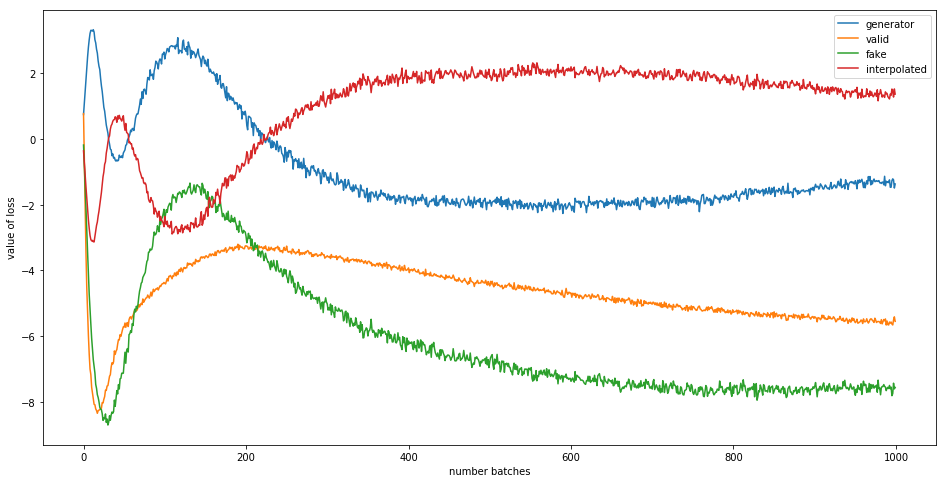

In [39]:
plt.figure(figsize=(16,8))
plt.plot(range(len(corr_metrics)), [i[0] for i in corr_metrics], label='generator')
plt.plot(range(len(corr_metrics)), [i[1][0] for i in corr_metrics], label='valid')
plt.plot(range(len(corr_metrics)), [i[1][1] for i in corr_metrics], label='fake')
plt.plot(range(len(corr_metrics)), [i[1][2] for i in corr_metrics], label='interpolated')
plt.xlabel('number batches')
plt.ylabel('value of loss')
plt.legend()
plt.show()


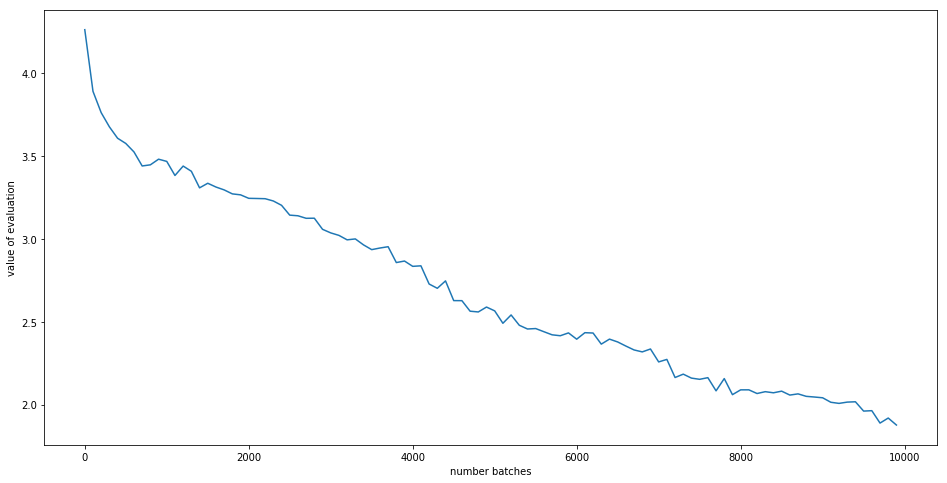

In [40]:
plt.figure(figsize=(16,8))
plt.plot(np.arange(len(metrics_all))*100, [i[0] for i in metrics_all], label='corr')
plt.xlabel('number batches')
plt.ylabel('value of evaluation')
plt.show()

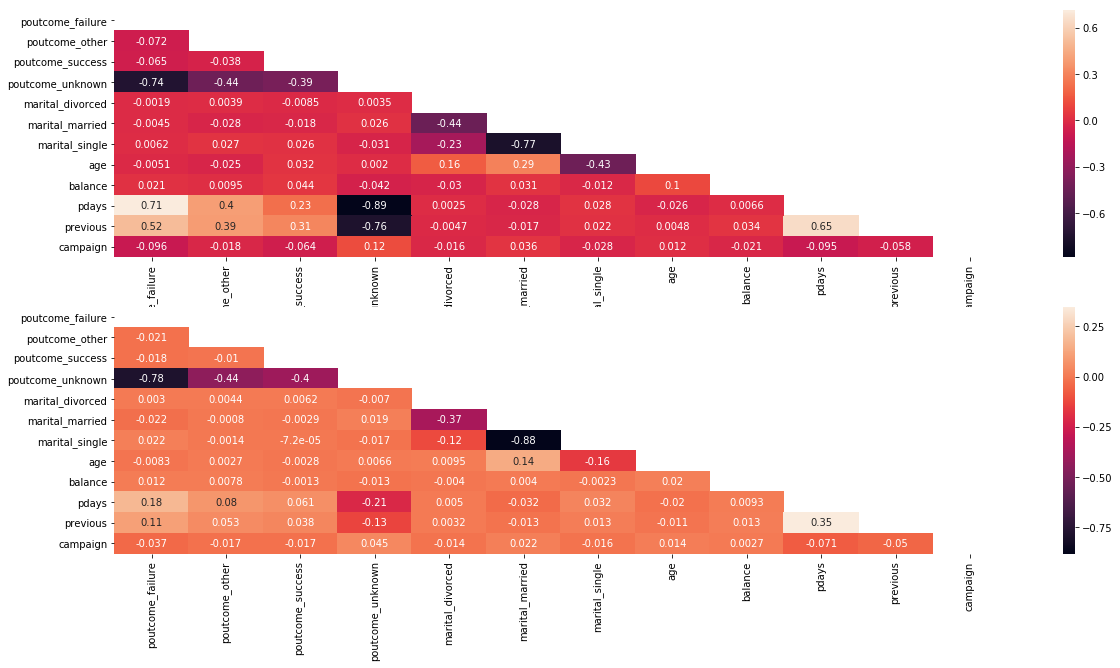

In [42]:
ar = np.random.normal(0, 1, (int(40000/NUM_ONE_SAMPLE), LATENT_DIM))
fake = generator.predict(ar)
fake = pd.DataFrame.from_records(fake.reshape(-1, NUM_FEATURES), columns=df_all.columns)
fake = encode(decode(fake), li_cat, li_cont)

rcorr = df_all.corr()
rcorr.values[np.triu_indices_from(rcorr,0)] = np.nan

fcorr = fake.corr()
fcorr.values[np.triu_indices_from(fcorr,0)] = np.nan
plt.figure(figsize=(20,10))
plt.subplot(211)
sns.heatmap(rcorr, annot=True)
plt.subplot(212)
sns.heatmap(fcorr, annot=True)
plt.show()

# Tasks 

Improve generated data:
    1. One of the straight-forward improvement would be to train more epochs until correlation difference converge.
    2. Try deeper architecture. To make it fast one might reduce number of nodes as well as latent spaces
    3. Add more features for analysis, such as education.

Compare results with VAE:
    1. Compare the results with data generated with VAE. What would be the difference in correlation? What is the average distance in nearest neghbors? How unsupervised learning algorithm performs?